In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
nevs                   = 10
topk                   = 5
ϵ                      = 0.25
num_steps              = 200
t_initial              = minimum(Time)
t_end                  = t_initial+60     # parameter value corresponding to ϵ=0
scale                  = 1
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

 28.909208 seconds (58.81 M allocations: 3.223 GiB, 3.06% gc time)


In [9]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [10]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

 18.007094 seconds (22.69 M allocations: 1.140 GiB, 1.34% gc time)
 18.046313 seconds (22.68 M allocations: 1.139 GiB, 3.26% gc time)
1/100
 15.212212 seconds (11.25 M allocations: 672.583 MiB, 0.47% gc time)
 14.982405 seconds (11.25 M allocations: 672.583 MiB, 0.52% gc time)
2/100
 15.179481 seconds (11.25 M allocations: 672.583 MiB, 0.48% gc time)
 14.699981 seconds (11.25 M allocations: 672.583 MiB, 0.44% gc time)
3/100
 15.311476 seconds (11.25 M allocations: 672.583 MiB, 0.44% gc time)
 14.694831 seconds (11.25 M allocations: 672.583 MiB, 0.52% gc time)
4/100
 15.129538 seconds (11.25 M allocations: 672.583 MiB, 0.45% gc time)
 14.767601 seconds (11.25 M allocations: 672.583 MiB, 0.46% gc time)
5/100
 15.215683 seconds (11.25 M allocations: 672.583 MiB, 0.44% gc time)
 14.620541 seconds (11.25 M allocations: 672.583 MiB, 0.48% gc time)
6/100
 15.365519 seconds (11.25 M allocations: 672.583 MiB, 0.47% gc time)
 14.614924 seconds (11.25 M allocations: 672.583 MiB, 0.49% gc time)
7/

57/100
 18.115956 seconds (11.25 M allocations: 672.583 MiB, 0.30% gc time)
 11.615934 seconds (11.25 M allocations: 672.583 MiB, 0.63% gc time)
58/100
 18.339305 seconds (11.25 M allocations: 672.583 MiB, 0.38% gc time)
 11.533477 seconds (11.25 M allocations: 672.583 MiB, 0.50% gc time)
59/100
 18.254041 seconds (11.25 M allocations: 672.583 MiB, 0.37% gc time)
 11.394199 seconds (11.25 M allocations: 672.583 MiB, 0.50% gc time)
60/100
 18.301757 seconds (11.25 M allocations: 672.583 MiB, 0.31% gc time)
 11.366864 seconds (11.25 M allocations: 672.583 MiB, 0.63% gc time)
61/100
 18.375132 seconds (11.25 M allocations: 672.583 MiB, 0.37% gc time)
 11.318907 seconds (11.25 M allocations: 672.583 MiB, 0.64% gc time)
62/100
 18.505189 seconds (11.25 M allocations: 672.583 MiB, 0.30% gc time)
 11.242367 seconds (11.25 M allocations: 672.583 MiB, 0.65% gc time)
63/100
 18.573644 seconds (11.25 M allocations: 672.583 MiB, 0.39% gc time)
 11.152944 seconds (11.25 M allocations: 672.583 MiB, 

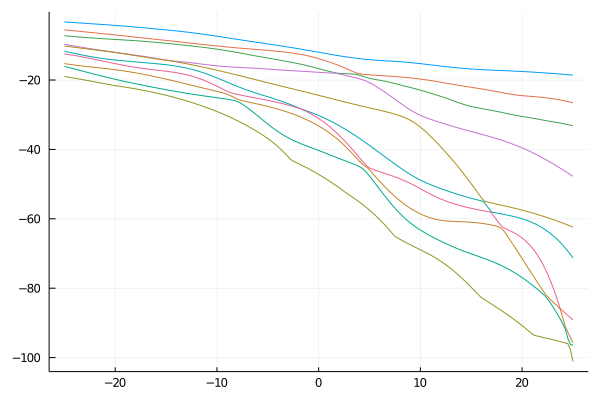

In [11]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

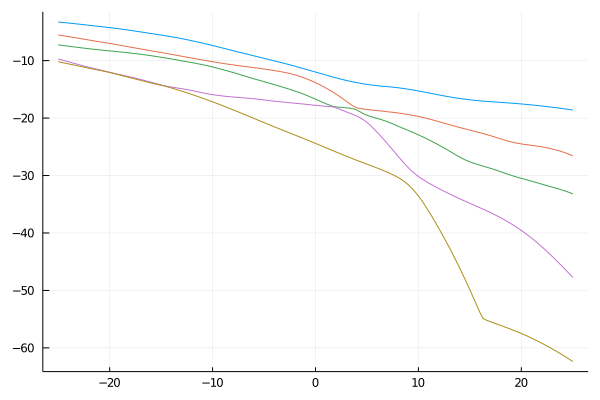

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1:topk], legend=false, fmt = :png)

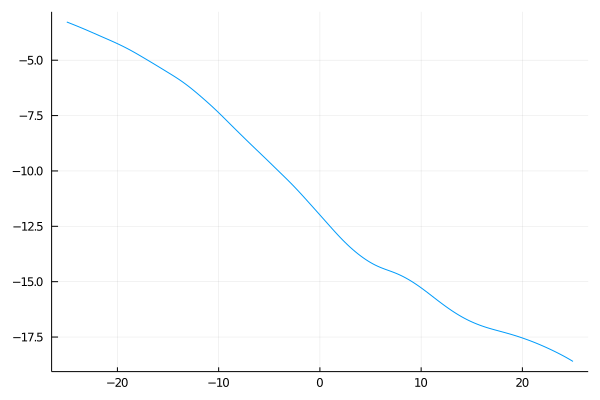

In [13]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1], legend=false, fmt = :png)

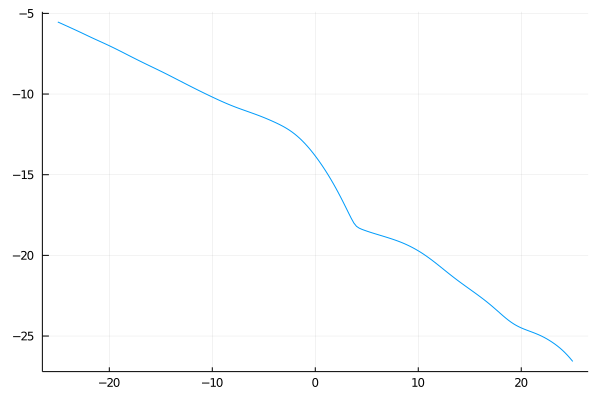

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

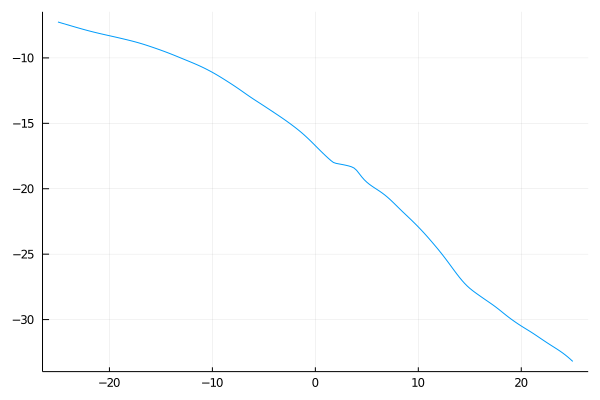

In [15]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

In [16]:
[range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs]

201×11 Array{Float64,2}:
 -25.0    -3.2746    -5.53399   -7.25522  …  -15.2666  -16.032    -18.9765
 -24.75   -3.31917   -5.60486   -7.31367     -15.3728  -16.2279   -19.1026
 -24.5    -3.36432   -5.6766    -7.37158     -15.4759  -16.4241   -19.2284
 -24.25   -3.41006   -5.74893   -7.42926     -15.5758  -16.6203   -19.3541
 -24.0    -3.45642   -5.82153   -7.48684     -15.6726  -16.816    -19.48
 -23.75   -3.50339   -5.89421   -7.5443   …  -15.7661  -17.0111   -19.6063
 -23.5    -3.55101   -5.96705   -7.60158     -15.8567  -17.2056   -19.7334
 -23.25   -3.59926   -6.04034   -7.65858     -15.9445  -17.3995   -19.8614
 -23.0    -3.64812   -6.11439   -7.71512     -16.03    -17.5927   -19.9907
 -22.75   -3.69754   -6.18936   -7.77097     -16.1136  -17.7852   -20.1212
 -22.5    -3.74745   -6.26513   -7.82587  …  -16.1957  -17.9769   -20.2533
 -22.25   -3.79765   -6.34125   -7.87955     -16.2767  -18.1674   -20.3868
 -22.0    -3.84794   -6.41712   -7.93179     -16.3571  -18.3564   -20.522
   

In [17]:
evs

201×10 Array{Float64,2}:
  -3.2746    -5.53399   -7.25522   -9.70929  …  -15.2666  -16.032    -18.9765
  -3.31917   -5.60486   -7.31367   -9.82918     -15.3728  -16.2279   -19.1026
  -3.36432   -5.6766    -7.37158   -9.95101     -15.4759  -16.4241   -19.2284
  -3.41006   -5.74893   -7.42926  -10.0745      -15.5758  -16.6203   -19.3541
  -3.45642   -5.82153   -7.48684  -10.1991      -15.6726  -16.816    -19.48
  -3.50339   -5.89421   -7.5443   -10.3246   …  -15.7661  -17.0111   -19.6063
  -3.55101   -5.96705   -7.60158  -10.4502      -15.8567  -17.2056   -19.7334
  -3.59926   -6.04034   -7.65858  -10.5755      -15.9445  -17.3995   -19.8614
  -3.64812   -6.11439   -7.71512  -10.6998      -16.03    -17.5927   -19.9907
  -3.69754   -6.18936   -7.77097  -10.8222      -16.1136  -17.7852   -20.1212
  -3.74745   -6.26513   -7.82587  -10.9419   …  -16.1957  -17.9769   -20.2533
  -3.79765   -6.34125   -7.87955  -11.0581      -16.2767  -18.1674   -20.3868
  -3.84794   -6.41712   -7.93179  -11.170

In [18]:
using DelimitedFiles

In [19]:
writedlm("D:/"*string(grid_resolution)*"_"*string(Integer(num_steps/2)*ϵ)*"_"*string(t_end-t_initial)*".csv", [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")